# Train and test split + Copying images into train and test folders

## 1. Reload images dataset

In [1]:
import pandas as pd

images_dataset_path = 'data/datasets/images.csv'
df_images = pd.read_csv(images_dataset_path)

display(df_images.columns)
display(df_images.index[:10])

RangeIndex(start=0, stop=10, step=1)

## 2. Preprocess the dataset

In [2]:
from modules.octa_video_util import _assign_tag
from modules.octa_video_util import filter_by_query

#### Create categorical field from tag priority list

In [3]:
# Create unique tag column based on class priority list
default_tag = 'normal'
tags_priority_list = ['alagamento', 'bolsão', 'lâmina', 'poça', 'transbordo']

df_images['tag'] = df_images['tags'].apply(lambda tags_list: _assign_tag(tags_list, tags_priority_list, default_tag))
display(df_images.tag.value_counts())

tag
normal        100031
poça           53218
lâmina          7979
bolsão          3612
transbordo      2237
alagamento      1417
Name: count, dtype: int64

#### Drop categories

In [4]:
df_images = df_images[df_images['tag'] != 'transbordo']

#### Binarize categorical variable

In [5]:
target_classes = ['lâmina', 'bolsão', 'alagamento']

# Binarize categorical variable from list of target classes
df_images['flood'] = df_images['tag'].isin(target_classes).astype(int)

display(df_images['flood'].value_counts())
print()
display(df_images.index[:10])

flood
0    153249
1     13008
Name: count, dtype: int64

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

#### Filter images

In [6]:
query_params = {'seen': True}

# Filter dataset of images by query
df_sample = filter_by_query(df_images, query_params).copy()

display(df_sample['flood'].value_counts())
print()
display(df_sample.index[:10])

flood
0    153249
1     13008
Name: count, dtype: int64

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

---
## 3. Data Exploration

#### Distribution of number of images in videos

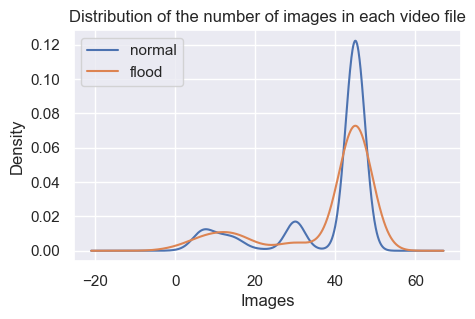

In [7]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
ax = df_sample[df_sample['flood'] == 0]['id_video'].value_counts().plot.kde(label='normal')
ax = df_sample[df_sample['flood'] == 1]['id_video'].value_counts().plot.kde(ax=ax, label='flood')

ax.set(title='Distribution of the number of images in each video file', xlabel='Images')
ax.legend()
plt.show()

---
## 4. Sampling

In [8]:
import numpy as np
import secrets
secrets.randbits(128)

def RNG():
    return np.random.default_rng(122807528840384100672342137672332424406)

# Example usage
# rng = RNG()
# idx = rng.choice(data.index, len(data), replace=replace, shuffle=False)

#### Sampling parameters

In [9]:
target_variable = 'flood'
multiclass_target_variable = 'tag'
groups_variable = 'code'

max_samples = 1000
replace = False
random_state = 0

#### Shuffle Samples

In [10]:
data = df_sample.copy()

data = data.sample(n=len(data), replace=replace, random_state=random_state)

display(data.index[:10])

Index([130257, 51815, 103322, 150756, 149791, 80417, 116786, 94433, 108433,
       28989],
      dtype='int64')

#### Get x and y (features and target variable)

In [11]:
# Get x and y
X = data.drop(target_variable, axis=1)
Y = data[target_variable].copy()

Y_multi = data[multiclass_target_variable] 
groups = data[groups_variable].copy()

Y.value_counts()

flood
0    153249
1     13008
Name: count, dtype: int64

#### Under sampling true categories

In [12]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='auto', random_state=random_state, replacement=replace)

x_res, y_multi_res = rus.fit_resample(X[Y==1], Y_multi[Y==1])
x_res = pd.concat([x_res, X[Y==0]])
y_multi_res = pd.concat([y_multi_res, Y_multi[Y==0]])
y_res = Y.loc[y_multi_res.index]

display(y_multi_res.value_counts())
print()
display(y_res.value_counts())
print()
display(y_res.index)

tag
normal        100031
poça           53218
alagamento      1417
bolsão          1417
lâmina          1417
Name: count, dtype: int64

flood
0    153249
1      4251
Name: count, dtype: int64

Index([ 30358,  64449,  56743,  39023,  39894,  54031,  50005,  17838,  56777,
        30400,
       ...
        52620,  48600, 112420,  86293, 122624,  97639,  95939, 152810, 117997,
        43567],
      dtype='int64', length=157500)

#### Undersampling target categories

In [13]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=random_state, replacement=replace)

x_res, y_res = rus.fit_resample(x_res, y_res)
groups_res = groups.loc[y_res.index].copy()

print('Total samples:', len(y_res))
y_res.value_counts()

print()
display(y_res.index)

Total samples: 8502



Index([ 46614, 127389,  64811,  67627, 112930,  80645,  63759, 114675, 167231,
       129953,
       ...
       135049,  24725, 135098,  24805, 116222,  24863,  25836,  51090,  13399,
        25716],
      dtype='int64', length=8502)

#### Optional · Sampling based on `max_samples`

In [14]:
y_res = pd.concat([
    y_res[y_res == 0].sample(int(max_samples / 2), replace=replace, random_state=random_state),
    y_res[y_res == 1].sample(int(max_samples / 2), replace=replace, random_state=random_state)
], axis=0)

x_res = X.loc[y_res.index].copy()
groups_res = groups.loc[y_res.index].copy()

display(y_res.value_counts())
print()
display(y_res.index)

flood
0    500
1    500
Name: count, dtype: int64

Index([152562,  28728, 102704,   5237, 112104,  19950,   8079,  37094, 127490,
        84836,
       ...
        25339, 114551,  61760, 140408, 135149, 104976,  51144,  13175,  36707,
        52391],
      dtype='int64', length=1000)

#### Frames per video distribution after sampling

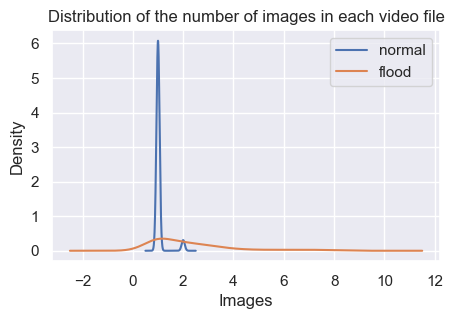

In [15]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

data_res = data.loc[y_res.index]

plt.figure(figsize=(5, 3))
ax = data_res[data_res['flood'] == 0]['id_video'].value_counts().plot.kde(label='normal')
ax = data_res[data_res['flood'] == 1]['id_video'].value_counts().plot.kde(ax=ax, label='flood')

ax.set(title='Distribution of the number of images in each video file', xlabel='Images')
ax.legend()
plt.show()

#### Sample per video

In [162]:
from IPython.display import clear_output as co

samples_per_video = 3

unique_video_ids = data['id_video'].unique()
n_videos = len(unique_video_ids)
data_sample = []

for id_video in unique_video_ids:
    video_images = data[data['id_video']==id_video].copy()

    # if not video_images['flood'].iloc[0]:
    if samples_per_video < len(video_images):
        video_images = video_images.sample(n=samples_per_video, replace=False, random_state=random_state)
    data_sample.append(video_images)

    i = len(data_sample)
    if not i % 10 or i == n_videos:
        co(True); print(f'Samples Taken: {i}/{n_videos}')

data = pd.concat(data_sample, axis=0)

Samples Taken: 4359/4359


---
## 5. Train and Test Splitting

#### Optional · Train test split

In [136]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x_res, y_res, test_size=0.3, shuffle=True, stratify=y_res, random_state=random_state)
train_index, test_index = Y_train.index, Y_test.index

####  Optional · Stratified group KFold split

Obs: Best split result

In [16]:
from sklearn.model_selection import StratifiedGroupKFold

# Stratified group KFold testing  split
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=False, random_state=None)
for i, (train_index, test_index) in enumerate(sgkf.split(x_res, y_res, groups_res)):
    # Get first split folder
    break

X_train = x_res.iloc[train_index]
Y_train = y_res.iloc[train_index]
groups_train = groups_res.iloc[train_index]

X_test = x_res.iloc[test_index]
Y_test = y_res.iloc[test_index]
groups_test = groups_res.iloc[test_index]

# Stratified group KFold validation split
sgkf = StratifiedGroupKFold(n_splits=9, shuffle=False, random_state=None)
for i, (train_index, val_index) in enumerate(sgkf.split(X_train, Y_train, groups_train)):
    break

X_val = X_train.iloc[val_index]
Y_val = Y_train.iloc[val_index]
groups_val = groups_train.iloc[val_index]

X_train = X_train.iloc[train_index]
Y_train = Y_train.iloc[train_index]
groups_train = groups_train.iloc[train_index]

print('Train index:', Y_train.index[:10])
print('Test index:', Y_test.index[:10])
print('Val index:', Y_val.index[:10])

Train index: Index([152562, 28728, 102704, 5237, 112104, 19950, 8079, 37094, 127490, 53874], dtype='int64')
Test index: Index([119203, 167208, 112587, 7612, 153113, 97275, 112665, 131489, 38230,
       153038],
      dtype='int64')
Val index: Index([84836, 105412, 59671, 85469, 39388, 150546, 17531, 118932, 150271,
       129556],
      dtype='int64')


#### Optional · Group shuffle split

In [56]:
# NOTE: This split is not deterministic even using random_state!=None
# NOTE: This split is not stratified
from sklearn.model_selection import GroupShuffleSplit

# Group shuffle split
gss = GroupShuffleSplit(n_splits=1, random_state=random_state, test_size=0.2)

# Get first split folder
for i, (train_index, test_index) in enumerate(gss.split(x_res, y_res, groups_res)):
    break

X_train = x_res.iloc[train_index]
X_test = x_res.iloc[test_index]

Y_train = y_res.iloc[train_index]
Y_test = y_res.iloc[test_index]

#### Report group count and train and test samples for each class (Missing reporting per group class)

In [18]:
def group_split_report(y_res, groups_res, Y_train, Y_test, Y_val):

    train_prct = len(Y_train) / len(y_res)
    test_prct = len(Y_test) / len(y_res)
    val_prct = len(Y_val) / len(y_res)
    groups_train = groups_res.loc[Y_train.index].unique()
    groups_test = groups_res.loc[Y_test.index].unique()
    groups_val = groups_res.loc[Y_val.index].unique()
    class_count = y_res.value_counts()
    train_class_count = Y_train.value_counts()
    test_class_count = Y_test.value_counts()
    val_class_count = Y_val.value_counts()
    train_class_prct = [train_class_count[0] / class_count[0], train_class_count[1] / class_count[1]]
    test_class_prct = [test_class_count[0] / class_count[0], test_class_count[1] / class_count[1]]
    val_class_prct = [val_class_count[0] / class_count[0], val_class_count[1] / class_count[1]]
    train_class_ratio = round(Y_train.value_counts(normalize=True).loc[0] * 100, 2)
    test_class_ratio = round(Y_test.value_counts(normalize=True).loc[0] * 100, 2)
    val_class_ratio = round(Y_val.value_counts(normalize=True).loc[0] * 100, 2)
    
    print('Groups intersecting train and test sets:', len(set(groups_train).intersection(groups_test)))
    print('Groups intersecting train and val sets:', len(set(groups_train).intersection(groups_val)))
    print('Groups intersecting test and val sets:', len(set(groups_test).intersection(groups_val)))
    print()
    
    stats = pd.DataFrame(
        [[len(groups_train), len(groups_test), len(groups_val)],
        [len(Y_train), len(Y_test), len(Y_val)],
        [round(train_prct * 100, 2), round(test_prct * 100, 2), round(val_prct * 100, 2)],
        [train_class_count[0], test_class_count[0], val_class_count[0]],
        [train_class_count[1], test_class_count[1], val_class_count[1]],
        [round(train_class_prct[0] * 100, 2), round(test_class_prct[0] * 100, 2), round(val_class_prct[0] * 100, 2)],
        [round(train_class_prct[1] * 100, 2), round(test_class_prct[1] * 100, 2), round(val_class_prct[1] * 100, 2)],
        [train_class_ratio, test_class_ratio, val_class_ratio]],
        columns=['train', 'test', 'val'], index=['groups', 'total', 'total (%)', '0', '1', '0 (%)', '1 (%)', 'class ratio (%)']
    ).T

    return stats


# Example usage

print('Total samples:', len(y_res))
stats = group_split_report(y_res, groups_res, Y_train, Y_test, Y_val)
display(stats)

Total samples: 1000
Groups intersecting train and test sets: 0
Groups intersecting train and val sets: 0
Groups intersecting test and val sets: 0



,groups,total,total (%),0,1,0 (%),1 (%),class ratio (%)
train,114.0,799.0,79.9,403.0,396.0,80.6,79.2,50.44
test,15.0,96.0,9.6,49.0,47.0,9.8,9.4,51.04
val,9.0,105.0,10.5,48.0,57.0,9.6,11.4,45.71


---
## 6. Copy images into train and test folders

#### Copy images with `train_index`and `test_index` into structured 'train' and 'test' folders

In [19]:
from modules.octa_video_util import copy_images_to_folders

base_directory = 'data/images'
target_directory = 'data/splits/sgkf-8-1-1'
# dataset = data.copy()
dataset = data.copy()
file_path_field = 'file_path'
label_field = 'flood'
train_indexes = list(Y_train.index)
test_indexes = list(Y_test.index)
val_indexes = list(Y_val.index)

copy_images_to_folders(
    base_directory, target_directory, dataset,
    train_indexes, test_indexes, val_indexes,
    file_path_field=file_path_field, tag_field=label_field
)

Copying images to train folders:
Processed 799/799 files (100.00%) - Found: 799/799
Copying images to test folders:
Processed 96/96 files (100.00%) - Found: 96/96
Copying images to val folders:


#### Save dataframe of sample images

In [20]:
target_directory = 'data/splits/sgkf-8-1-1'

data_train = data.loc[Y_train.index]
data_test = data.loc[Y_test.index]
data_val = data.loc[Y_val.index]

data_train['set'] = 'train'
data_test['set'] = 'test'
data_val['set'] = 'val'

data_split_df = pd.concat([data_train, data_test, data_val])

data_split_df.to_csv(f'{target_directory}/images.csv')
print(f'split dataframe saved with shape: {data_split_df.shape}')

split dataframe saved with shape: (1000, 13)


#### Count save images

In [21]:
import os

target_directory = 'data/splits/sgkf-8-1-1'

print('train:', len(os.listdir(f'{target_directory}/train/0')), len(os.listdir(f'{target_directory}/train/1')))
print('test:', len(os.listdir(f'{target_directory}/test/0')), len(os.listdir(f'{target_directory}/test/1')))
print('val:', len(os.listdir(f'{target_directory}/val/0')), len(os.listdir(f'{target_directory}/val/1')))

train: 403 396
test: 49 47
val: 48 57
